In [4]:
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiLineString, LineString, shape
import requests
import pandas as pd
from datetime import datetime
import numpy as np

In [24]:
class ArmsTradeRegisterRequest:
    def __init__(self, include_open_deals = "on", seller_country_code = "UK", buyer_country_code = "", low_year = 1950, high_year = datetime.today().year-1, armament_category_id = "", buyers_or_sellers = "buyers", filetype="csv"):
        self.include_open_deals = include_open_deals
        self.selselToseller_country_code = seller_country_code
        self.seller_country_code = seller_country_code
        self.buyer_country_code = buyer_country_code
        self.low_year = low_year
        self.high_year = high_year
        self.armament_category_id = armament_category_id
        self.buyers_or_sellers = buyers_or_sellers
        self.filetype = filetype
        self.sum_deliveries = "on"
        self.Submit4 = "Download"

    def send(self):
        fname = f'{self.seller_country_code}{self.low_year}_to_{self.high_year}.{self.filetype}'
        with requests.post("https://armstrade.sipri.org/armstrade/html/export_trade_register.php", data = vars(self), stream = True) as stream:
            with open(fname, 'wb') as file:
                for chunk in stream.iter_content(chunk_size=8192): 
                    file.write(chunk)
        return fname

    def file(self): return f'{self.seller_country_code}{self.low_year}_to_{self.high_year}.{self.filetype}'


In [69]:
request = ArmsTradeRegisterRequest(seller_country_code = 'RUS', low_year=2013, high_year=2022, filetype="csv")
response = request.send()

with open(request.file(), 'r') as file:
    df = pd.read_csv(file).replace([np.nan],0).replace(['Russia'],'Russian Federation')

In [70]:
world.loc[(world['COUNTRYAFF'].isin(df['seller'].unique()) & (world['COUNTRYAFF'] == world['COUNTRY']))]

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Length,SHAPE_Area,geometry,centre
184,185,Russian Federation,RU,Russian Federation,RU,1536.28715,2931.526082,"MULTIPOLYGON (((-179.99999 68.98010, -179.9580...",POINT (88.38098 59.46450)


In [71]:
df.head()

,tidn,buyercod,sellercod,odat,odai,onum,onai,ldat,term,desig2,...,coprod,nrdel,nrdelai,delyears,buyer,seller,status,tivunit,tivorder,tivdel
0,54430.0,AFG,RUS,2013.0,0,12.0,0,2013.0,0,Mi-8MT/Mi-17,...,L,12.0,0,2013,Afghanistan,Russian Federation,N,6.75,81.0,81.0
1,56589.0,AFG,RUS,2013.0,0,30.0,0,2014.0,0,Mi-8MT/Mi-17,...,L,30.0,0,2014,Afghanistan,Russian Federation,N,6.75,202.5,202.5
2,62381.0,ALG,RUS,2014.0,X,40.0,X,2018.0,0,53-65,...,L,40.0,X,2018,Algeria,Russian Federation,N,1.10,44.0,44.0
3,38428.0,ALG,RUS,2006.0,X,900.0,X,2016.0,0,57E6,...,0,900.0,X,2012-2016,Algeria,Russian Federation,N,0.25,225.0,225.0
4,39939.0,ALG,RUS,2006.0,X,38.0,X,2016.0,0,96K9 Pantsyr-S1,...,L,38.0,X,2012-2016,Algeria,Russian Federation,N,11.00,418.0,418.0


In [67]:
df['seller']

0      Russia
1      Russia
2      Russia
3      Russia
4      Russia
        ...  
436    Russia
437    Russia
438    Russia
439    Russia
440       NaN
Name: seller, Length: 441, dtype: object

In [65]:
world['COUNTRYAFF'].str.contains('Russia').any()
#world['COUNTRYAFF'].values.str.contains(df['seller']).any()

True

In [44]:
world.loc[(world['COUNTRYAFF'].values.str.contains(df['seller']).any())]

AttributeError: 'numpy.ndarray' object has no attribute 'str'

In [79]:
world = gpd.read_file("world.geojson")
world["centre"] = world["geometry"].representative_point()
world.head()

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Length,SHAPE_Area,geometry,centre
0,1,Afghanistan,AF,Afghanistan,AF,50.803210,62.566714,"MULTIPOLYGON (((61.27655 35.60725, 61.29638 35...",POINT (65.20079 33.93968)
1,2,Albania,AL,Albania,AL,9.625038,3.073540,"MULTIPOLYGON (((19.57083 41.68527, 19.58195 41...",POINT (20.03108 41.12798)
2,3,Algeria,DZ,Algeria,DZ,70.540082,213.513461,"MULTIPOLYGON (((4.60335 36.88791, 4.63555 36.8...",POINT (0.60236 28.06264)
3,4,American Samoa,AS,United States,US,0.600124,0.013720,"MULTIPOLYGON (((-170.74390 -14.37555, -170.749...",POINT (-170.74312 -14.31590)
4,5,Andorra,AD,Andorra,AD,0.937352,0.055585,"MULTIPOLYGON (((1.44584 42.60194, 1.48653 42.6...",POINT (1.58154 42.55323)


In [73]:
from sklearn.preprocessing import minmax_scale
def norm(x):
    return minmax_scale(np.sqrt(x))


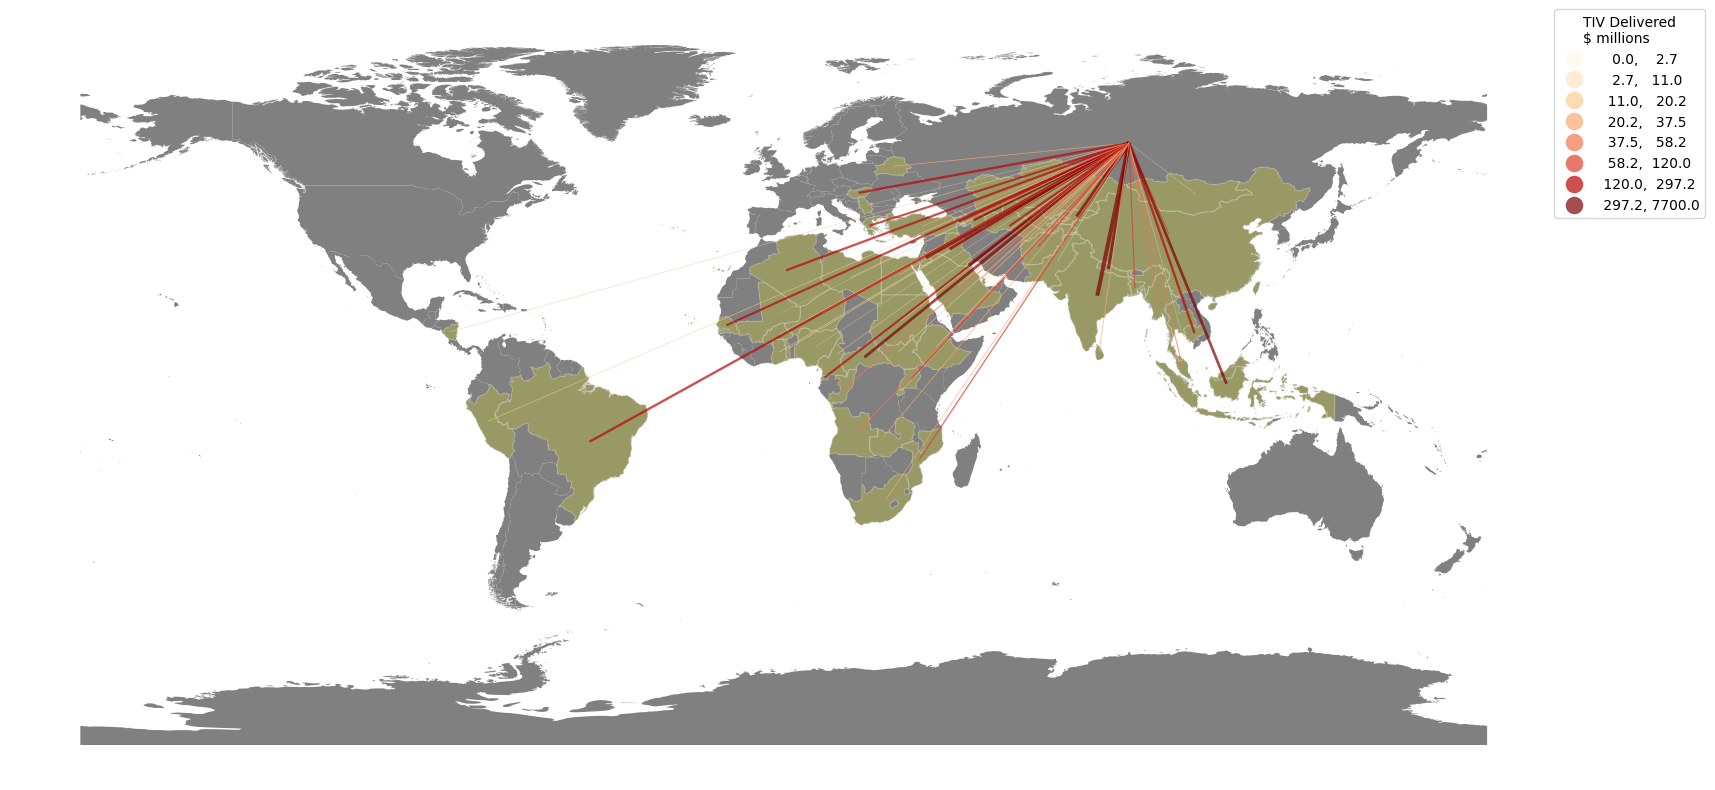

In [80]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_aspect('equal')
ax.set_axis_off();
world.plot(ax=ax,color='grey')

seller = world.loc[(world['COUNTRYAFF'].isin(df['seller'].unique()) & (world['COUNTRYAFF'] == world['COUNTRY']))]
buyers = world.loc[(world['COUNTRYAFF'].isin(df['buyer'].unique()) & (world['COUNTRYAFF'] == world['COUNTRY']))]
buyers.plot(alpha=0.2, ax=ax,color='yellow', edgecolor='lightgrey')

sxy = [seller.centre.values[0].x, seller.centre.values[0].y]

lines = gpd.GeoSeries([LineString([sxy,bxy]) for bxy in buyers.centre], crs='epsg:4326')
gdf = gpd.GeoDataFrame(df.loc[(df['buyer'].isin(world['COUNTRYAFF']))], geometry=lines, crs=4326)

tivdel_norm = norm(gdf.tivdel)
gdf.plot(gdf.tivdel,
         cmap='OrRd',
         legend_kwds={'loc':'upper right', 
                      'bbox_to_anchor':(1.1, 1.01),
                      'fmt':'{:.1f}',
                      'markerscale':1.26, 
                      'title_fontsize':'medium', 
                      'fontsize':'medium'},
         ax=ax,
         lw=tivdel_norm*10,
         alpha=0.7, 
         k= 8, 
         scheme='quantiles',
         legend=True)
ax.get_legend().set_title("TIV Delivered\n$ millions")

In [76]:
world['flow'] = lines

In [78]:
world.explore()

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Length,SHAPE_Area,geometry,centre,flow
0,1,Afghanistan,AF,Afghanistan,AF,50.803210,62.566714,"MULTIPOLYGON (((61.27655 35.60725, 61.29638 35...",POINT (65.20079 33.93968),"LINESTRING (88.38098 59.46450, 65.20079 33.93968)"
1,2,Albania,AL,Albania,AL,9.625038,3.073540,"MULTIPOLYGON (((19.57083 41.68527, 19.58195 41...",POINT (20.03108 41.12798),"LINESTRING (88.38098 59.46450, 0.60236 28.06264)"
2,3,Algeria,DZ,Algeria,DZ,70.540082,213.513461,"MULTIPOLYGON (((4.60335 36.88791, 4.63555 36.8...",POINT (0.60236 28.06264),"LINESTRING (88.38098 59.46450, 18.87685 -11.90..."
3,4,American Samoa,AS,United States,US,0.600124,0.013720,"MULTIPOLYGON (((-170.74390 -14.37555, -170.749...",POINT (-170.74312 -14.31590),"LINESTRING (88.38098 59.46450, 44.84799 40.07464)"
4,5,Andorra,AD,Andorra,AD,0.937352,0.055585,"MULTIPOLYGON (((1.44584 42.60194, 1.48653 42.6...",POINT (1.58154 42.55323),"LINESTRING (88.38098 59.46450, 48.56528 40.53809)"
